<a href="https://colab.research.google.com/github/AK18k/ex2_1/blob/avis_lab/ex2_latenight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Clone the GIT repository including py and data files     +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

!git clone -b avis_lab https://github.com/AK18k/ex2_1



Cloning into 'ex2_1'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 138 (delta 12), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (138/138), 2.41 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [3]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Mount Colab drive to access files on the cloud           +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/ex2_1'
DATA_PATH = '/content/ex2_1/data/ptb'
os.chdir('/content/ex2_1')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data	 ex2_latenight.ipynb  main.ipynb  README.md  train.txt
data.py  generate.py	      model.py	  test.txt   valid.txt


In [4]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Import python packages                                   +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np

import argparse
import time
import math
import os
import torch.onnx

import data
import model



In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


In [5]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Load data and creat dictionary                           +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import os
from io import open
import torch

class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)

        return ids


In [6]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Model class                                              +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError as e:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""") from e
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Class to keep and plot results                           +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix, file_name):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}. Dropout = {args.dropout}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show() 

  plt.savefig(file_name) 


In [21]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Classes and vunctions to prepare and run network         +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



parser = argparse.ArgumentParser(description='PyTorch Wikitext-2 RNN/LSTM/GRU Language Model')
parser.add_argument('--data', type=str, default='./data/ptb',
                    help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM',
                    help='type of network (RNN_TANH, RNN_RELU, LSTM, GRU)')
parser.add_argument('--emsize', type=int, default=1500,
                    help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=200,
                    help='number of hidden units per layer')
parser.add_argument('--nlayers', type=int, default=2,
                    help='number of layers')
parser.add_argument('--lr', type=float, default=10,
                    help='initial learning rate')
parser.add_argument('--clip', type=float, default=0.25,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=40,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=20, metavar='N',
                    help='batch size')
parser.add_argument('--bptt', type=int, default=35,
                    help='sequence length')
parser.add_argument('--dropout', type=float, default=0,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--tied', action='store_true',
                    help='tie the word embedding and softmax weights')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true', default=True,
                    help='use CUDA')
parser.add_argument('--mps', action='store_true', default=False,
                        help='enables macOS GPU training')
parser.add_argument('--log-interval', type=int, default=200, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
parser.add_argument('--onnx-export', type=str, default='',
                    help='path to export the final model in onnx format')
parser.add_argument('--nhead', type=int, default=2,
                    help='the number of heads in the encoder/decoder of the transformer model')
parser.add_argument('--dry-run', action='store_true',
                    help='verify the code and the model')

args, unknown = parser.parse_known_args()

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda.")
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    if not args.mps:
        print("WARNING: You have mps device, to enable macOS GPU run with --mps.")

use_mps = args.mps and torch.backends.mps.is_available()
if args.cuda:
    device = torch.device("cuda")
    print('CUDA is active')
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

###############################################################################
# Load data
###############################################################################

# Create Batched train, validate and test datasets
corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args.batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)

model = RNNModel(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout, args.tied).to(device)

criterion = nn.NLLLoss()

###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args.bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(args.batch_size)
       
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args.bptt, lr,
                elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
           
            total_loss = 0
            start_time = time.time()
      
    results_m.add_result(math.exp(cur_loss), 'train') #add train ppl to result matrix


# Loop over epochs.
lr = args.lr
best_val_loss = None


CUDA is active


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0.,

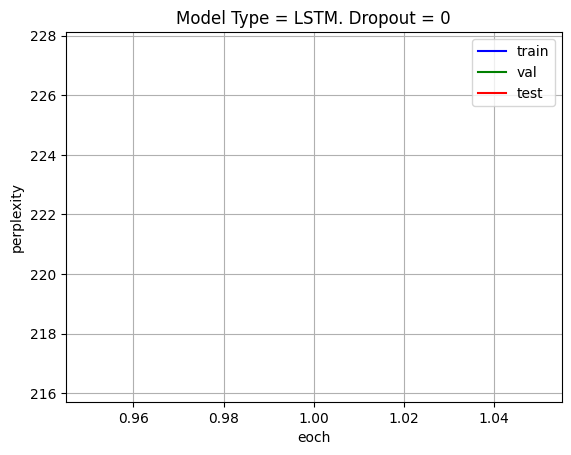

<Figure size 640x480 with 0 Axes>

In [22]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#    Main Cell to run the Network                             +
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# At any point you can hit Ctrl + C to break out of training early.
try:
    results_m = Result_Matrix(args.model) #create a result matrix for the model
  
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        
        
        results_m.add_result(math.exp(val_loss), 'val') #add val ppl to result matrix

        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    # Currently, only rnn model supports flatten_parameters function.
    if args.model in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

results_m.add_result(math.exp(test_loss), 'test') #add test ppl to result matrix

plot_results(results_m, f'{results_m.model_name} Dropout = {args.dropout != 0}.jpg')

